In [ ]:
# Marina Reggiani-Guzzo
# Oct, 2021

In [1]:
# fix window size, jupyter width = 100% page width
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

# from now, those are the libraries for the BDT

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

import xgboost
from xgboost import XGBClassifier

pd.options.display.max_columns = None 

In [2]:
# create "plots" directory
import os
if(os.path.isdir('plots')==False):
    os.makedirs('plots')
    print('Making folder "plots".')
else: print('The folder "plots" already exists!')

The folder "plots" already exists!


### General Functions

In [3]:
# ======================== #
#                          #
#   ACTIVE VOLUME LIMITS   #
#                          #
# ======================== #

# unit = cm
tpc_xmin = 0
tpc_xmax = 254.3
tpc_ymin = -115.0
tpc_ymax = 117.0
tpc_zmin = 0.6
tpc_zmax = 1036.4

# ====================== #
#                        #
#    CREATE DATAFRAME    #
#                        #
# ====================== #

def create_dataframe(file, family):
    
    # ------------ #
    # import trees #
    # ------------ # 
    
    T_pot = uproot.open(file)['wcpselection/T_pot']
    T_KINE = uproot.open(file)['wcpselection/T_KINEvars']
    T_BDT = uproot.open(file)['wcpselection/T_BDTvars']
    T_PFeval = uproot.open(file)['wcpselection/T_PFeval']
    T_eval = uproot.open(file)['wcpselection/T_eval']
    
    # --- create reco dataframes
    df_pot_reco    = T_pot.pandas.df(pot_vars_reco, flatten=False)
    df_KINE_reco   = T_KINE.pandas.df(kine_vars_reco, flatten=False)
    df_BDT_reco    = T_BDT.pandas.df(bdt_vars_reco, flatten=False)
    df_PFeval_reco = T_PFeval.pandas.df(pfeval_vars_reco, flatten=False)
    df_eval_reco   = T_eval.pandas.df(eval_vars_reco, flatten=False)    
    
    df = pd.concat([df_KINE_reco, df_BDT_reco, df_PFeval_reco, df_eval_reco], axis=1)
    
    # --- create truth dataframes
    if((family=='MC') | (family=='NUE')):
        df_pot_true    = T_pot.pandas.df(pot_vars_true, flatten=False)
        df_KINE_true   = T_KINE.pandas.df(kine_vars_true, flatten=False)
        df_BDT_true    = T_BDT.pandas.df(bdt_vars_true, flatten=False)
        df_PFeval_true = T_PFeval.pandas.df(pfeval_vars_true, flatten=False)
        df_eval_true   = T_eval.pandas.df(eval_vars_true, flatten=False)
        
        df = pd.concat([df, df_KINE_true, df_BDT_true, df_PFeval_true, df_eval_true], axis=1)
        
    # ----------------------------------------------------------------- #
    #  fix weight_cv and weight_spline (only overlay and intrinsic nue) #
    # ----------------------------------------------------------------- #
    
    if((family=='MC') | (family=='NUE')):
        df['weight_cv'] = np.where((df.weight_cv <= 0), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv > 30), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.nan), 1, df.weight_cv)
        df['weight_cv'] = np.where((df.weight_cv == np.inf), 1, df.weight_cv)
        df['weight_cv'] = np.where((df['weight_cv'].isna()), 1, df.weight_cv)
        df['weight_spline'] = np.where((df.weight_spline <= 0), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline > 30), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.nan), 1, df.weight_spline)
        df['weight_spline'] = np.where((df.weight_spline == np.inf), 1, df.weight_spline)
        df['weight_spline'] = np.where((df['weight_spline'].isna()), 1, df.weight_spline)
                
    # ------------- #
    # fix nue_score #
    # ------------- #
    
    df['nue_score'] = np.where((df.nue_score == np.inf), 16, df.nue_score)
    df['nue_score'] = np.where((df.nue_score == -np.inf), -16, df.nue_score)   
    
    # ------------------------ #
    # calculate POT and weight #
    # ------------------------ #
    
    POT_tot = 0
    W_ = 1
    
    if((family=='MC') | (family=='NUE')): 
        POT_tot = sum(df_pot_reco.pot_tor875)
        if(POT_tot!=0): W_ = POT_data/POT_tot # <--- up to here calculated
        elif(POT_tot==0): W_ = 1
        df.loc[:,'weight_genie'] = df['weight_cv']*df['weight_spline']
        df.loc[:,'weight'] = [W_]*df.shape[0]*df['weight_genie']
        
    elif(family=='DATA'): 
        POT_tot = POT_data
        W_ = 1
        df.loc[:,'weight'] = [W_]*df.shape[0]
        
    elif(family=='EXT'): 
        POT_tot = POT_ext
        W_ = (POT_data/POT_tot)*0.98   # 0.98 = NuMI correction factor
        df.loc[:,'weight'] = [W_]*df.shape[0]

    # ------------------- #
    # add extra variables #
    # ------------------- #
    
    df = calc_costheta(df)  # cos_theta of the shower wrt the NuMI beam direction
    
    if((family=='MC') | (family=='NUE')): 
        # new variables that depend on true information should be here
        df = calc_vtx_reco_true_dist(df)    
    
    # -------------------------------------- #
    # delete dataframes to save memory space #
    # -------------------------------------- #
    
    del df_pot_reco
    del df_KINE_reco
    del df_BDT_reco 
    del df_PFeval_reco
    del df_eval_reco
    
    if((family=='MC') | (family=='NUE')):
        del df_pot_true
        del df_KINE_true
        del df_BDT_true
        del df_PFeval_true
        del df_eval_true    
        
    print('[%s] POT %5.2e      %7i entries' % (family,POT_tot,len(df)))

    return df, POT_tot

# ========================================= #
#                                           #
#    FUNCTIONS TO CREATE EXTRA VARIABLES    #
#                                           #
# ========================================= #

def calc_costheta(df):
    
    # position of the NuMI target
    # those values are manually added to the lines below
    # if you want to change them, make sure you also update the lines below!!
    v_targ_uboone = [-31387.58422, -3316.402543, -60100.2414]

    # take the vector from the NuMI target to the neutrino vertex
    df.eval('vec_targ_vtx_X = reco_nuvtxX - (-31387.58422)', inplace=True)
    df.eval('vec_targ_vtx_Y = reco_nuvtxY - (-3316.402543)', inplace=True)
    df.eval('vec_targ_vtx_Z = reco_nuvtxZ - (-60100.2414)', inplace=True)
    
    # get reco shower vector (workaround that is working, for some reason I can't access it if I don't do this workaround, maybe it's somethind to do with the name containing [ ])
    df.loc[:,'shower_momentum_X'] = df["reco_showerMomentum[0]"]
    df.loc[:,'shower_momentum_Y'] = df["reco_showerMomentum[1]"]
    df.loc[:,'shower_momentum_Z'] = df["reco_showerMomentum[2]"]
    df.loc[:,'shower_energy'] = df["reco_showerMomentum[3]"]
    
    # calculate the norm of the vectors
    df.eval('norm_vec_targ_vtx = sqrt(vec_targ_vtx_X**2 + vec_targ_vtx_Y**2 + vec_targ_vtx_Z**2)', inplace=True)
    df.eval('norm_vec_shower = sqrt(shower_momentum_X**2 + shower_momentum_Y**2 + shower_momentum_Z**2)', inplace=True)
    
    # calculate cos_theta
    df.eval('cos_theta = ((vec_targ_vtx_X * shower_momentum_X) + (vec_targ_vtx_Y * shower_momentum_Y) + (vec_targ_vtx_Z * shower_momentum_Z) )/(norm_vec_targ_vtx * norm_vec_shower)', inplace=True)

    return df

def calc_vtx_reco_true_dist(df):
    df_copy = df.copy()
    df_copy.eval('dist_vtxX = reco_nuvtxX - truth_corr_nuvtxX', inplace=True)
    df_copy.eval('dist_vtxY = reco_nuvtxY - truth_corr_nuvtxY', inplace=True)
    df_copy.eval('dist_vtxZ = reco_nuvtxZ - truth_corr_nuvtxZ', inplace=True)
    df_copy.eval('dist_vtx = sqrt(dist_vtxX**2 + dist_vtxY**2 + dist_vtxZ**2)', inplace=True)
    return df_copy

def calc_particle_multiplicity(filename):
    
    # this function is only used for the second BDT

    # --- open file and variables
    
    pfeval_particle = ['reco_mother','reco_pdg','reco_Ntrack', 'run', 'subrun', 'event']
    T_PFeval = uproot.open(filename)['wcpselection/T_PFeval']
    DF = T_PFeval.pandas.df(pfeval_particle, flatten=True)
    
    # --- queries to split into different variables
    
    df_Neutron = DF.query('((reco_pdg==2112) | (reco_pdg==-2112)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Neutron.groupby(['entry'])['reco_pdg'].transform('count')

    df_Muon = DF.query('((reco_pdg==13) | (reco_pdg==-13)) & reco_mother==0')
    DF.loc[:,'countMuon'] = df_Muon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Kaon = DF.query('((reco_pdg==321) | (reco_pdg==-321)) & reco_mother==0')
    DF.loc[:,'countKaon'] = df_Kaon.groupby(['entry'])['reco_pdg'].transform('count')

    df_Pion = DF.query('((reco_pdg==211) | (reco_pdg==-211)) & reco_mother==0')
    DF.loc[:,'countNeutron'] = df_Pion.groupby(['entry'])['reco_pdg'].transform('count')

    df_Proton = DF.query('((reco_pdg==2212) | (reco_pdg==-2212)) & reco_mother==0')
    DF.loc[:,'countProton'] = df_Proton.groupby(['entry'])['reco_pdg'].transform('count')

    df_Gamma = DF.query('((reco_pdg==22) | (reco_pdg==-22)) & reco_mother==0')
    DF.loc[:,'countGamma'] = df_Gamma.groupby(['entry'])['reco_pdg'].transform('count')

    df_Electron = DF.query('((reco_pdg==11) | (reco_pdg==-11)) & reco_mother==0')
    DF.loc[:,'countElectron'] = df_Electron.groupby(['entry'])['reco_pdg'].transform('count')
    
    # --- concat everything together
    
    #df_concat = pd.concat([DF,df_Neutron,df_Muon,df_Kaon,df_Pion,df_Proton,df_Gamma,df_Electron], axis=1)
    #df_concat = df_concat.loc[:,~df_concat.columns.duplicated()]
    
    df_concat = DF
    
    # --- create an extra column with the max number in the count... column
    
    df_concat.loc[:,'Num_Neutron'] = df_concat.groupby(['entry'])['countNeutron'].transform(max)
    df_concat.loc[:,'Num_Muon'] = df_concat.groupby(['entry'])['countMuon'].transform(max)
    df_concat.loc[:,'Num_Kaon'] = df_concat.groupby(['entry'])['countKaon'].transform(max)
    df_concat.loc[:,'Num_Proton'] = df_concat.groupby(['entry'])['countProton'].transform(max)
    df_concat.loc[:,'Num_Gamma'] = df_concat.groupby(['entry'])['countGamma'].transform(max)
    df_concat.loc[:,'Num_Electron'] = df_concat.groupby(['entry'])['countElectron'].transform(max)
    
    # --- get the first subentry only --> the same as unflatten the dataframe
    
    df_concat.groupby('entry').first()
    
    # --- create the final dataframe with the columns that we want
    
    df_final = df_concat[['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron', 'run', 'subrun', 'event']].groupby('entry').first()
    df_final = df_final.fillna(0)
    
    # --- return final dataframe
    
    return df_final

# ======================== #
#                          #
#   APPLY SELECTION CUTS   #
#                          #
# ======================== #

def applyCuts(label, dfData, dfEXT, dfIntrinsicNue, dfOverlay, count, cut, print_lengths, make_plots):
    
    # cut = BDT score cut used for label=BDT1_nina only, set the rest to -1
    # print_lengths = print the number of entries after the cut (True/False)
    # make_plots = create a pdf with the plots
    
    print('\n---------- Applying: %s' % label)
    
    # ----- apply the cuts to the input dataframes
    
    if((label=='None')):
        # don't do anything with the dataframe, so basically the applyCuts function
        # is being called to draw the histograms at this specific stage of the selection
        # cuts
        df_data = dfData
        df_ext = dfEXT
        df_intrinsic_nue = dfIntrinsicNue
        df_overlay = dfOverlay        
    elif(label=='GenNuSelection'):
        print('           Guarantees a Reconstructed Neutrino\n')
        # generic neutrino selection
        # guarantees a reconstructed neutrino
        df_data = apply_gen_nu_selection(dfData)
        df_ext = apply_gen_nu_selection(dfEXT)
        df_intrinsic_nue = apply_gen_nu_selection(dfIntrinsicNue)
        df_overlay = apply_gen_nu_selection(dfOverlay)
    elif(label=='inFV'):
        print('           Neutrino Reconstructed Vertex inFV\n')
        # neutrino reconstructed vertex inFV
        df_data = apply_inFV(dfData)
        df_ext = apply_inFV(dfEXT)
        df_intrinsic_nue = apply_inFV(dfIntrinsicNue)
        df_overlay = apply_inFV(dfOverlay)
    elif(label=='ShowerCut'):
        print('           Guarantees a Reconstructed Shower\n')
        # guarantees a reconstructed shower 
        # important for my analysis as cos_theta depends on a reco shower
        df_data = apply_showerCut(dfData)
        df_ext = apply_showerCut(dfEXT)
        df_intrinsic_nue = apply_showerCut(dfIntrinsicNue)
        df_overlay = apply_showerCut(dfOverlay)
    elif(label=='BDT1_nina'):
        # in this case, use my BDT to select nue+antinue
        df_data = dfData[dfData.bdt_score>cut]
        df_ext = dfEXT[dfEXT.bdt_score>cut]
        df_overlay = dfOverlay[dfOverlay.bdt_score>cut]
        df_intrinsic_nue = dfIntrinsicNue[dfIntrinsicNue.bdt_score>cut]
    elif(label=='BDT1_wirecell'):
        # use the BDT score developed by wirecell to select nue+antinue
        df_data = isRecoNueCCWC(dfData)
        df_ext = isRecoNueCCWC(dfEXT)
        df_overlay = isRecoNueCCWC(dfOverlay)
        df_intrinsic_nue = isRecoNueCCWC(dfIntrinsicNue)
    elif(label=='outFV'):
        df_data = apply_outFV(dfData) # Holly
        
    # if you want to include a new cut, simply add it to the list below, to the commented out block
    #elif(label=='NewCut'): 
        #df_data = apply_newcut(dfData)
        #df_ext = apply_newcut(dfEXT)
        #df_intrinsic_nue = apply_newcut(dfIntrinsicNue)
        #df_overlay = apply_newcut(dfOverlay)
        
    if(print_lengths==True):
        print('[DATA] %7i entries' % len(df_data))
        print('[EXT]  %7i entries' % len(df_ext))
        print('[NUE]  %7i entries' % len(df_intrinsic_nue))
        print('[MC]   %7i entries' % len(df_overlay))
        print('')
        
    # ----- save the number of entries per dataframe
    arr_nentries_nue.append(len(df_intrinsic_nue)/POT_data)
    arr_nentries_mc.append(len(df_overlay)/POT_data)
    arr_nentries_data.append(len(df_data)/POT_data)
    arr_nentries_ext.append(len(df_ext)/POT_data)
    arr_nentries_x.append(count)
    arr_nentries_x_label.append(label)
    
    count = count+1
    
    # make stacked histograms
    if(make_plots == True):
        plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label)
        
    # return the updated dataframes
    return df_data, df_ext, df_intrinsic_nue, df_overlay, count 

def apply_gen_nu_selection(df):    
    # the generic neutrino selection guarantees that there is a reconstructed neutrino
    df_ = df[df.numu_cc_flag >= 0]
    return df_

def apply_inFV(df):
    dist = 3 # distance from the boundaries
    df_ = df[((df.reco_nuvtxX>(tpc_xmin+dist)) & (df.reco_nuvtxX<(tpc_xmax-dist))) &
             ((df.reco_nuvtxY>(tpc_ymin+dist)) & (df.reco_nuvtxY<(tpc_ymax-dist))) &
             ((df.reco_nuvtxZ>(tpc_zmin+dist)) & (df.reco_nuvtxZ<(tpc_zmax-dist)))]    
    return df_

def apply_showerCut(df):    
    # this cut guarantees that there is a reconstructed shower
    # shower_vtxX = shower_vtxY = shower_vtxZ = shower_energy = -1 for events without a reconstructed shower
    # so it is safe to select shower_energy!=-1 since shower_energy==-1 is not a physical quantity
    df_ = df[df.shower_energy!=-1] 
    return df_

''' # Holly
def apply_outFV(df):
    dist = 3
    df_ = #make the cut here
    return df_
'''

# ======================================== #
#                                          #
#   LIST OF PLOTS FOR THE SELECTION CUTS   #
#                                          #
# ======================================== #

def plots_for_SelectionCuts(df_data, df_ext, df_intrinsic_nue, df_overlay, label):
    
    # this function makes all the plots that you want to plot throughout the pre-selection cuts
    
    # --- MC/DATA comparison
       
    dist = 15
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxX", "plots/%s_nuvtxX" % label, "Reco neutrino Vertex X [cm]", tpc_xmin-dist, tpc_xmax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxY", "plots/%s_nuvtxY" % label, "Reco neutrino Vertex Y [cm]", tpc_ymin-dist, tpc_ymax+dist, 25, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "reco_nuvtxZ", "plots/%s_nuvtxZ" % label, "Reco neutrino Vertex Z [cm]", tpc_zmin-dist, tpc_zmax+dist, 25, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "flash_time", "plots/%s_flash_time" % label, r"Flash Time [$\mu$s]", 4, 18, 50, POT_data)
    
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "cos_theta", "plots/%s_costheta" % label, r"cos($\theta$)", -1.2, 1.2, 25, POT_data)
    
    # variables used for the BDT -- check if they make sense
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_reco_Enu", "plots/%s_kine_reco_Enu" % label, "Reco Neutrino Energy [MeV]", 0, 1600, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_pio_vtx_dis", "plots/%s_kine_pio_vtx_dis" % label, r"$\pi^0$ Vertex Distance [cm]", 0, 200, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "kine_pio_energy_1", "plots/%s_kine_pio_energy_1" % label, r"$\pi^0$ Reco Energy [MeV]", 0, 1000, 30, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "numu_cc_flag", "plots/%s_numu_cc_flag" % label, "Reco Neutrino Energy [MeV]", -1, 1, 10, POT_data)
    plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, "nue_score", "plots/%s_nue_score" % label, "nue_score", -20, 20, 40, POT_data)
    
    # add here if you want to plot new variables, Holly
    
def isTopo_reco(df):
    df_ = df # don't apply any reconstructed topology
    #df_ = df[(df.numu_cc_flag>=0) & (df.nue_score>7)]  # nue+antinueCC for wirecell
    return df_

def isRecoNueCCWC(df):
    df_ = df[(df.numu_cc_flag>=0) & (df.nue_score>7)]
    return df_
    
def plot_mc_data_comparison(df_overlay, df_intrinsic_nue, df_data, df_ext, var, filename, xaxis, xmin, xmax, nbins, POT_DATA):
    
    print('Plotting stacked histogram: %s' % xaxis)
    
    plt.close() # close figure to save memory    
    
    # ----- restrict the dataframes to the range that is going to be displayed 
    
    df_overlay = df_overlay[(df_overlay[var]>=xmin) & (df_overlay[var]<=xmax)]
    df_intrinsic_nue = df_intrinsic_nue[(df_intrinsic_nue[var]>=xmin) & (df_intrinsic_nue[var]<=xmax)]
    df_data = df_data[(df_data[var]>=xmin) & (df_data[var]<=xmax)]
    df_ext = df_ext[(df_ext[var]>=xmin) & (df_ext[var]<=xmax)]
        
    # ----- get the number of entries
    
    n_overlay = len(df_overlay)
    n_intrinsic_nue = len(df_intrinsic_nue)
    n_data = len(df_data)
    n_ext = len(df_ext)
    
    # ----- check if the events are uniquely classified
    #check_classification_multiplicity(df_overlay, 'Overlay')
    
    # ----- get TRUE topologies
    
    # cosmic
    df_cosmic = isCosmic(df_overlay)
    n_cosmic = len(df_cosmic)
    df_overlay = delete_dataframe(df_overlay,df_cosmic) # delete overlay and bad reconstructed events

    # outFV
    df_outFV = isOutFV(df_overlay)
    n_outFV = len(df_outFV)
    df_overlay = delete_dataframe(df_overlay,df_outFV) # exclude events outside the FV

    # numuCCpi0
    df_numuCCpi0 = isNumuCCpi0(df_overlay)
    n_numuCCpi0 = len(df_numuCCpi0)

    # numuCC
    df_numuCC = isNumuCC(df_overlay)
    n_numuCC = len(df_numuCC)

    # NCpi0
    df_ncpi0 = isNCpi0(df_overlay)
    n_ncpi0 = len(df_ncpi0)

    # NC
    df_nc = isNC(df_overlay)
    n_nc = len(df_nc)
    
    # nueCC
    # not used for the stacked histogram, only checking if all events
    df_nueCC = isNueCC(df_overlay)
    n_nueCC = len(df_nueCC)
    
    # nuebarCC
    df_nuebarCC = isNuebarCC(df_overlay)
    n_nuebarCC = len(df_nuebarCC)

    #print('\nOverlay (%i entries)' % n_overlay)
    #print('Cosmic    %10i' % n_cosmic)
    #print('outFV     %10i' % n_outFV)
    #print('NumuCCpi0 %10i' % n_numuCCpi0)
    #print('NumuCC    %10i' % n_numuCC)
    #print('NCpi0     %10i' % n_ncpi0)
    #print('NC        %10i' % n_nc)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC)
    #print('Total     %10i' % (n_cosmic + n_outFV + n_numuCCpi0 + n_numuCC + n_ncpi0 + n_nc + n_nueCC + n_nuebarCC))
    
    # nueCC
    df_nueCC = isNueCC(df_intrinsic_nue)
    n_nueCC = len(df_nueCC)

    # nuebarCC
    df_nuebarCC = isNuebarCC(df_intrinsic_nue)
    n_nuebarCC = len(df_nuebarCC)
    
    #print('\nIntrinsic Nue (%i entries)' % n_intrinsic_nue)
    #print('NueCC     %10i' % n_nueCC)
    #print('NuebarCC  %10i' % n_nuebarCC) 
    #print('Total     %10i' % (n_nueCC + n_nuebarCC))
    
    # get entries
    hist_list = [isTopo_reco(df_cosmic)[var],
                 isTopo_reco(df_outFV)[var],
                 isTopo_reco(df_numuCCpi0)[var],
                 isTopo_reco(df_numuCC)[var],
                 isTopo_reco(df_ncpi0)[var],
                 isTopo_reco(df_nc)[var],
                 isTopo_reco(df_nueCC)[var],
                 isTopo_reco(df_nuebarCC)[var],
                 isTopo_reco(df_ext)[var]]

    hist_data = isTopo_reco(df_data)[var]

    # weights
    w_list = [isTopo_reco(df_cosmic).weight,
              isTopo_reco(df_outFV).weight,
              isTopo_reco(df_numuCCpi0).weight,
              isTopo_reco(df_numuCC).weight,
              isTopo_reco(df_ncpi0).weight,
              isTopo_reco(df_nc).weight,
              isTopo_reco(df_nueCC).weight,
              isTopo_reco(df_nuebarCC).weight,
              isTopo_reco(df_ext).weight]

    w_data = isTopo_reco(df_data).weight
    
    # colors
    c_list = ['paleturquoise',
              'springgreen',
              'limegreen',
              'aqua',
              'orange',
              'saddlebrown',
              'grey',
              'brown',
              'gold']

    c_data = 'black'

    # labels
    label_list = ['Cosmic (%1.1f)'%(sum(w_list[0])),
                  'outFV (%1.1f)'%(sum(w_list[1])),
                  r'$\nu_{\mu}$ CC $\pi^{0}$ (%1.1f)'%(sum(w_list[2])),
                  r'$\nu_{\mu}$ CC (%1.1f)'%(sum(w_list[3])),
                  r'NC $\pi^{0}$ (%1.1f)'%(sum(w_list[4])),
                  'NC (%1.1f)'%(sum(w_list[5])),
                  r'$\nu_{e}$ CC (%1.1f)'%(sum(w_list[6])),
                  r'$\bar{\nu}_{e}$ CC (%1.1f)'%(sum(w_list[7])),
                  'EXT (%1.1f)'%(sum(w_list[8]))]

    label_data = 'Data (%1.1f)'%(sum(w_data))

    # ========== stacked histogram
    
    legend_size = 12
    xrange = (xmin ,xmax) 
    axis_label_size = 18
    ticks_size = 14

    # configure the canvas
    fig, axs = plt.subplots(2, 1, figsize=(10,10), gridspec_kw=dict(height_ratios=[4,1]), sharex=True)
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, # position of top part of the top pad
                        wspace=0.2, 
                        hspace=0.1) # distance between plots
    
    # plot stacked histogram
    hist_stacked, bins_stacked, counts_stacked = axs[0].hist(hist_list, bins=nbins, range=(xmin,xmax), weights=w_list, color=c_list, label=label_list, stacked=True)     
    data_hist, bins_ = np.histogram(hist_data, weights=w_data, bins=nbins, range=xrange)
    err_bar = [np.sqrt(x) for x in data_hist]
    mid = 0.5*(bins_[1:] + bins_[:-1])
    axs[0].errorbar(mid, data_hist, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')   
    
    # get the histograms individually
    hist8 = axs[1].hist(hist_list[8], bins=nbins, weights=w_list[8], range=xrange, color=c_list[8], label=label_list[8], stacked=True) # EXT
    hist7 = axs[1].hist(hist_list[7], bins=nbins, weights=w_list[7], range=xrange, color=c_list[7], label=label_list[7], stacked=True) # nuebarCC
    hist6 = axs[1].hist(hist_list[6], bins=nbins, weights=w_list[6], range=xrange, color=c_list[6], label=label_list[6], stacked=True) # nueCC
    hist5 = axs[1].hist(hist_list[5], bins=nbins, weights=w_list[5], range=xrange, color=c_list[5], label=label_list[5], stacked=True) # NC
    hist4 = axs[1].hist(hist_list[4], bins=nbins, weights=w_list[4], range=xrange, color=c_list[4], label=label_list[4], stacked=True) # NCpi0
    hist3 = axs[1].hist(hist_list[3], bins=nbins, weights=w_list[3], range=xrange, color=c_list[3], label=label_list[3], stacked=True) # numuCC
    hist2 = axs[1].hist(hist_list[2], bins=nbins, weights=w_list[2], range=xrange, color=c_list[2], label=label_list[2], stacked=True) # numuCCpi0
    hist1 = axs[1].hist(hist_list[1], bins=nbins, weights=w_list[1], range=xrange, color=c_list[1], label=label_list[1], stacked=True) # outFV
    hist0 = axs[1].hist(hist_list[0], bins=nbins, weights=w_list[0], range=xrange, color=c_list[0], label=label_list[0], stacked=True) # cosmic
    axs[1].clear() # clear the axis so we can simply plot the ratio
    
    # ========== ratio
    
    # calculate ratio
    ratio = []
    ratio_stat = []
    ratio_error_sqrt = []
    ratio_center = []
    
    mc_total = []   # number of entries
    mc_stat = []    # stat error
    
    data_total = [] # number of entries
    data_stat = []  # stat error
    
    for i in range(0,nbins): 
        
        # get total entries
        mc_total.append(hist0[0][i] + hist1[0][i] + hist2[0][i] + hist3[0][i] + hist4[0][i] + hist5[0][i] + hist6[0][i] + hist7[0][i] + hist8[0][i])
        data_total.append(data_hist[i])
        
        # calculate stat uncertainties
        mc_stat.append(np.sqrt(mc_total[i]))
        data_stat.append(np.sqrt(data_total[i]))
        
        # calculate ratio: Data/MC
        if(mc_total[i]!=0): ratio.append(data_total[i]/mc_total[i])
        else: ratio.append(0)
        
        ratio_center.append(1) # ratio should be centered at 1
        
        # calculate ratio uncertainty
        if(mc_total[i]!=0): 
            ratio_stat_first = ((data_stat[i]/mc_total[i])**2)+(((data_total[i]*mc_stat[i])/(mc_total[i]**2))**2)  # before taking the sqrt
            ratio_stat.append(np.sqrt(ratio_stat_first))
        #if(mc_total[i]!=0): ratio_stat.append(np.sqrt(data_total[i])/mc_total[i])
        else: ratio_stat.append(0)
        
    # plot ratio    
    axs[1].plot(mid, ratio, marker='o', color='black', linewidth=0)
    
    # plot ratio stat uncertainty (bar)
    err_bar = [x for x in ratio_stat]
    axs[1].errorbar(mid, ratio, xerr=0.5*xrange[1]/nbins, yerr=err_bar, color=c_data, label=label_data, fmt='o')
    
    # ========== draw gray area error
    
    # for the stacked histogram
    # the gray area error represents the MC stat uncertainty
    upvals = np.append((np.array(mc_total)+np.array(mc_stat)),(np.array(mc_total)+np.array(mc_stat))[-1])
    lowvals = np.append((np.array(mc_total)-np.array(mc_stat)),(np.array(mc_total)-np.array(mc_stat))[-1])
    axs[0].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # for the ratio
    # the gray area error represents the ratio stat uncertainty, that was calculated by propagating the uncertainty
    upvals = np.append((np.array(ratio_center)+np.array(ratio_stat)),(np.array(ratio_center)+np.array(ratio_stat))[-1])
    lowvals = np.append((np.array(ratio_center)-np.array(ratio_stat)),(np.array(ratio_center)-np.array(ratio_stat))[-1])
    axs[1].fill_between(bins_, lowvals, upvals, step='post', color='gray', alpha=0.3, zorder=2)
    
    # ========== final touch on the appearance
    
    # top pad
    axs[0].set_ylim(bottom=0)
    axs[0].legend(loc='best', ncol=3, prop={'size': 12})
    axs[0].set_ylabel('Entries', size=axis_label_size, loc='top')
    axs[0].set_title(r'MicroBooNE NuMI Data: %1.1e POT' % POT_DATA, size=20, loc='left')
    axs[0].xaxis.set_tick_params(labelsize=ticks_size)
    axs[0].yaxis.set_tick_params(labelsize=ticks_size)
    # find the maximum to make space for the legend (multiply max by 1.5)
    max_data = np.max(data_total)
    max_mc = np.max(mc_total)
    max_all = 0
    if(max_data>max_mc): max_all = max_data
    else: max_all = max_mc
    axs[0].set_ylim((0,max_all*1.5))
    
    # bottom pad
    axs[1].set_ylabel('Data/MC', size=axis_label_size, loc='center')
    axs[1].set_xlabel('%s' % xaxis, size=axis_label_size)
    axs[1].xaxis.set_tick_params(labelsize=ticks_size)
    axs[1].yaxis.set_tick_params(labelsize=ticks_size)
    axs[1].set_ylim([0.9, 1.1])
    
    # draw horizontal line at y=1
    x_values = [xmin,xmax]
    y_values = [1,1]
    axs[1].plot(x_values, y_values, color='black', linestyle='dashed')  
    
    # ========== save plot
    
    plt.savefig('%s.pdf' % filename)
    #plt.show(0)
    
# =================== #
#                     #
#   TRUE TOPOLOGIES   #
#                     #
# =================== #

def isCosmic(df):
    df_ = df[((df.match_completeness_energy <= df.truth_energyInside * 0.1) | (df.truth_energyInside <= 0))]
    return df_

def notCosmic(df):
    df_ = df[((df.match_completeness_energy > df.truth_energyInside * 0.1) & (df.truth_energyInside > 0))]
    return df_

def isOutFV(df):
    df_ = df[(df.truth_vtxInside==0)]                            # vtx outFV
    return df_

def isNueCC(df):
    df_ = df[(df.truth_nuPdg==12) &                              # nue
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNuebarCC(df):
    df_ = df[(df.truth_nuPdg==-12) &                             # nuebar
             (df.truth_isCC==1)]                                 # CC
    return df_

def isNumuCCpi0(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNumuCC(df):
    df_ = df[((df.truth_nuPdg==14) | (df.truth_nuPdg==-14)) &    # numu
             (df.truth_isCC==1) &                                # CC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

def isNCpi0(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio>0)]                              # with pi0
    return df_

def isNC(df):
    df_ = df[(df.truth_isCC==0) &                                # NC
             (df.truth_NprimPio<=0)]                             # without pi0 (to avoid overlap with the topology above)
    return df_

# ===================== #
#                       #
#   UTILITY FUNCTIONS   #
#                       #
# ===================== #

def delete_dataframe(df1,df2):
    # delete df2 from df1
    df_ = pd.concat([df1,df2,df2]).drop_duplicates(keep=False)
    return df_

# ================================================================================================
# Definition of the functions used for the BDT training

# ================= #
#                   #
#   FINAL MESSAGE   #
#                   #
# ================= #

print('All done.')

All done.


# Welcome to the Code! :)

## Define Dataframes (DATA, EXT, Intrinsic Nue, Overlay)

In [4]:
# =============== #
#                 #
#   INPUT FILES   #
#                 #
# =============== #

# files can be found here: https://www.phy.bnl.gov/xqian/talks/wire-cell/LEEana/processed_checkout_rootfiles/

datafile = '/uboone/data/users/mguzzo/wirecell/checkout_data_numi_run1_full_FHC.root'                                       # data = beam-on
extfile = '/uboone/data/users/mguzzo/wirecell/checkout_data_extnumi_run1.root'                                              # ext = beam-off
mcfile = '/uboone/data/users/mguzzo/wirecell/checkout_prodgenie_numi_nu_overlay_run1.root'                                  # intrinsice nue = nue + antinue (only)  --> with particle flow information
intrinsicfile = '/uboone/data/users/mguzzo/wirecell/checkout_prodgenie_numi_intrinsic_nue_overlay_run1.root'                # MC = numu + antinumu + nue + antinue   --> with particle flow information

tortgt_wcut = 1.922e+20                                  # DATA information
EA9CNT_wcut = 5064302.0                                  # DATA information
EXT_NUMIwin_FEMBeamTriggerAlgo = 2466466.930000          # EXT information

# Calculated POT
POT_data = tortgt_wcut
POT_ext = POT_data/(EA9CNT_wcut/EXT_NUMIwin_FEMBeamTriggerAlgo)

# ====================================== #
#                                        #
#   VARIABLES TO IMPORT FROM THE FILES   #
#                                        #
# ====================================== #

# make sure to distinguish reco from true variables as true information
# does not exist for beam-off and beam-on data ;D

# --- RECO variables
kine_vars_reco   = ['kine_reco_Enu',                                    # kinetic energy for the reconstructed neutrino
                    'kine_pio_vtx_dis',
                    'kine_pio_energy_1']
bdt_vars_reco    = ['numu_cc_flag',
                    'nue_score',                                        # nue_score>7 = likely to be nue/antinue
                    'numu_score']
pot_vars_reco    = ['pot_tor875']                                       # variable that saves the POT
pfeval_vars_reco = ['reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ',        # reconstructed neutrino vertex [cm]
                    #'reco_mother',                                     # indicates from what is the mother particle, if neutrino => reco_mother=0 (only available for particle multiplicity)
                    #'reco_pdg',                                        # PDG of the neutrino interaction daughter particles (only available for particle multiplicity)
                    #'reco_Ntrack',                                     # number of daugther tracks saved for a given neutrino interaction (only available for particle multiplicity)
                    'run',                                              # run number
                    'subrun',                                           # subrun number
                    'event',                                            # event number  
                    'reco_showerMomentum']                              # shower momentum 4-vector (px,py,pz,E) (keep it as the last variable)
eval_vars_reco   = ['match_found',
                    'stm_eventtype',
                    'stm_lowenergy',
                    'flash_time',
                    'stm_LM',
                    'stm_TGM',
                    'stm_STM',
                    'stm_FullDead',
                    'stm_clusterlength'] 

# --- TRUE variables
kine_vars_true   = []
bdt_vars_true    = []
pot_vars_true    = []
pfeval_vars_true = ['truth_corr_nuvtxX',                                # sce true neutrino vertex
                    'truth_corr_nuvtxY',                                # sce true neutrino vertex
                    'truth_corr_nuvtxZ',                                # sce true neutrino vertex
                    'truth_NprimPio']
eval_vars_true   = ['truth_isCC',                                       # 1 = CC interaction, 0 = NC interaction
                    'truth_nuPdg',                                      # true neutrino PDG
                    'truth_vtxInside',                                  # 1 = true neutrino vertex inside FV
                    'match_completeness_energy',
                    'weight_cv',
                    'weight_spline',
                    'truth_energyInside']

# ===================== #
#                       #
#   CREATE DATAFRAMES   #
#                       #
# ===================== #

df_data_original, POT_data = create_dataframe(datafile,'DATA')              # reco only
df_ext_original, POT_ext = create_dataframe(extfile,'EXT')                  # reco only
df_intrinsic_nue_original, POT_nue = create_dataframe(intrinsicfile,'NUE')  # true and reco
df_overlay_original, POT_mc = create_dataframe(mcfile,'MC')                 # true and reco

print('Obs: POTs should be ~e20')
print('\nYour dataframes are ready!')

[DATA] POT 1.92e+20       583288 entries
[EXT] POT 9.36e+19       243325 entries
[NUE] POT 2.26e+22       121934 entries
[MC] POT 1.06e+21       422841 entries
Obs: POTs should be ~e20

Your dataframes are ready!


## Apply Pre-Selection Cuts


---------- Applying: None
[DATA]  583288 entries
[EXT]   243325 entries
[NUE]   121934 entries
[MC]    422841 entries


---------- Applying: GenNuSelection
           Guarantees a Reconstructed Neutrino

[DATA]   29175 entries
[EXT]     3231 entries
[NUE]    97717 entries
[MC]    128140 entries


---------- Applying: inFV
           Neutrino Reconstructed Vertex inFV

[DATA]   26911 entries
[EXT]     2811 entries
[NUE]    94989 entries
[MC]    121642 entries


---------- Applying: ShowerCut
           Guarantees a Reconstructed Shower

[DATA]   11329 entries
[EXT]     1046 entries
[NUE]    89895 entries
[MC]     57037 entries


---------- Applying: BDT1_wirecell
[DATA]     449 entries
[EXT]        0 entries
[NUE]    47887 entries
[MC]      2328 entries



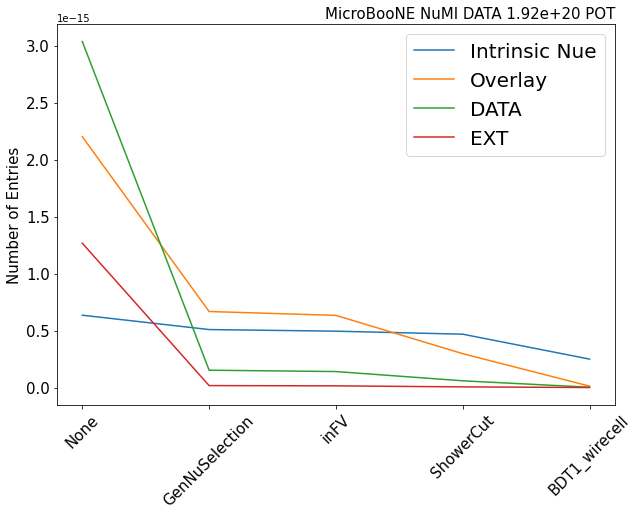

In [5]:
count = 0 # don't touch it

arr_nentries_nue = []
arr_nentries_mc = []
arr_nentries_data = []
arr_nentries_ext = []
arr_nentries_x = []
arr_nentries_x_label = []

df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('None', df_data_original, df_ext_original, df_intrinsic_nue_original, df_overlay_original, count, -1, True, False)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('GenNuSelection', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, True, False)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('inFV', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, True, False)
#df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('outFV', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, True, False)  # Holly (to study dirt)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('ShowerCut', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, True, False)
df_data, df_ext, df_intrinsic_nue, df_overlay, count = applyCuts('BDT1_wirecell', df_data, df_ext, df_intrinsic_nue, df_overlay, count, -1, True, False)

# plot the number of entries throughout the pre-selection cuts
size_letter = 15
plt.close()
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.plot(arr_nentries_x, arr_nentries_nue, label='Intrinsic Nue')
plt.plot(arr_nentries_x, arr_nentries_mc, label='Overlay')
plt.plot(arr_nentries_x, arr_nentries_data, label='DATA')
plt.plot(arr_nentries_x, arr_nentries_ext, label='EXT')
plt.ylabel('Number of Entries', fontsize=size_letter)
plt.title('MicroBooNE NuMI DATA %3.2e POT' % POT_data, loc='right', fontsize=size_letter)
plt.yticks(fontsize=size_letter)
ax.set_xticks(arr_nentries_x)
ax.set_xticklabels(arr_nentries_x_label, rotation=+45, fontsize=size_letter)
ax.legend(loc='best', ncol=1, prop={'size': 20})
plt.show()

In [16]:
# --- check the number of entries of each kind that survived to the pre-selection cuts

def print_nentries(df, label):
    
    df_antinue = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    df_nue = df[(df.truth_nuPdg==12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    
    # remove df_antinue and df_nue from the input df
    df_rest = delete_dataframe(df,df_antinue)
    df_rest = delete_dataframe(df_rest, df_nue)
    
    ratio = 0
    if(label=='MC'): ratio = POT_data/POT_mc
    elif(label=='NUE'): ratio = POT_data/POT_nue
        
    print('[%s]:' % label)
    print('> nue        %6i (%3.2f%%)' % (len(df_nue), 100*len(df_nue)/len(df)))
    print('> antinue    %6i (%3.2f%%)' % (len(df_antinue), 100*len(df_antinue)/len(df)))
    print('> rest       %6i (%3.2f%%)' % (len(df_rest), 100*len(df_rest)/len(df)))
    print('')
    
print_nentries(df_overlay, 'MC')
print_nentries(df_intrinsic_nue, 'NUE')

[MC]:
> nue          1681 (72.21%)
> antinue       412 (17.70%)
> rest          235 (10.09%)

[NUE]:
> nue         38516 (80.43%)
> antinue      8923 (18.63%)
> rest          448 (0.94%)



## Electron Antineutrino BDT

This part of the code is inspired by Davio's code: https://github.com/LArbys/1L1PSelection/blob/davio_june4update/DL_BDTTraining_1mu1p-prime.ipynb

Joshua Mills, Nick Kamp and Ran Itay are MicroBooNE BDT experts good to talk to

In [7]:
# ============================= #
#                               #
#   ADD PARTICLE MULTIPLICITY   #
#                               #
# ============================= #

# --- create dataframes with the particle multiplicity information, the file must contain the particle flow information for that
df_overlay_multiplicity = calc_particle_multiplicity(mcfile)
df_intrinsic_nue_multiplicity = calc_particle_multiplicity(intrinsicfile)

# --- merge the dataframe with the particle multiplicity information, and the dataframe with the events after the selection cuts
df_overlay = pd.merge(df_overlay, df_overlay_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
df_intrinsic_nue = pd.merge(df_intrinsic_nue, df_intrinsic_nue_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')

In [8]:
# ========================= #
#                           #
#   SIGNAL AND BACKGROUND   #
#                           #
# ========================= #

# --- define the dataframe that will be used for the second BDT
df_bdt = pd.concat([df_intrinsic_nue,df_overlay], ignore_index=True) # merge intrinsic nue + overlay for a better nue/antinue stat

def isSignal(df):
    df_ = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1)]        # antinueCC
    df_ = df_[df_.dist_vtx<1]                                   # good vertex reconstruction, less than 1 cm apart
    df_ = notCosmic(df_)                                        # good event reconstruction, not labelled as cosmic
    return df_

df_signal = isSignal(df_bdt)
df_background = delete_dataframe(df_bdt,df_signal) # background is everything that is not signal

if((len(df_signal)+len(df_background))!=(len(df_bdt))): print('   > Ooops! Check your signal/background definition!')

[13:10:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




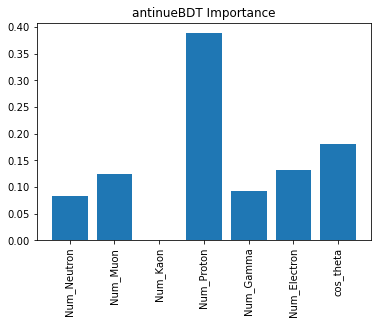

Accuracy = fraction of the time the BDT classifies an object correctly!
Accuracy Test:   83.31895121141719
Accuracy Train:  83.79800853485064
TestAcc - TrainAcc =  -0.47905732343345164


In [9]:
# ====================== #
#                        #
#   START BDT TRAINING   #
#                        #
# ====================== #

from numpy import asarray

myvars = ['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron','cos_theta']

# proton angular distribution
# energy distribution
# pion being reconstructed as muon?

X = df_signal[myvars].values.tolist()
Y_cos = df_background[myvars].values.tolist()

Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.3 # play around with this number?
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]

antinueBDT = XGBClassifier(silent = False,
                           scale_pos_weight = 1,
                           learning_rate = 0.01,
                           colsample_bytree = 0.8,
                           objective = 'binary:logistic',
                           subsample = 0.8,
                           n_estimators = 1000,
                           max_depth = 6,
                           gamma = 5,
                           use_label_encoder=False)

antinueBDT.fit(x_train, y_train, eval_metric = ['auc', 'error']) # fit bdt to data

y_checkV = antinueBDT.predict(x_test)
y_checkT = antinueBDT.predict(x_train)

predictionsV = [round(value) for value in y_checkV]
predictionsT = [round(value) for value in y_checkT]
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100.

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('antinueBDT Importance')
plt.bar(range(len(antinueBDT.feature_importances_)), antinueBDT.feature_importances_)
plt.xticks(range(len(antinueBDT.feature_importances_)), myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100.
print('Accuracy = fraction of the time the BDT classifies an object correctly!')
print("Accuracy Test:  ",acc_test*100)
print("Accuracy Train: ",acc_train*100)
print("TestAcc - TrainAcc = ",accuracy_diff)

In [10]:
# calculate antinue_score and save it in the dataframes
df_overlay.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_overlay[myvars])[:,1]
df_intrinsic_nue.loc[:,'antinue_score'] = antinueBDT.predict_proba(df_intrinsic_nue[myvars])[:,1]

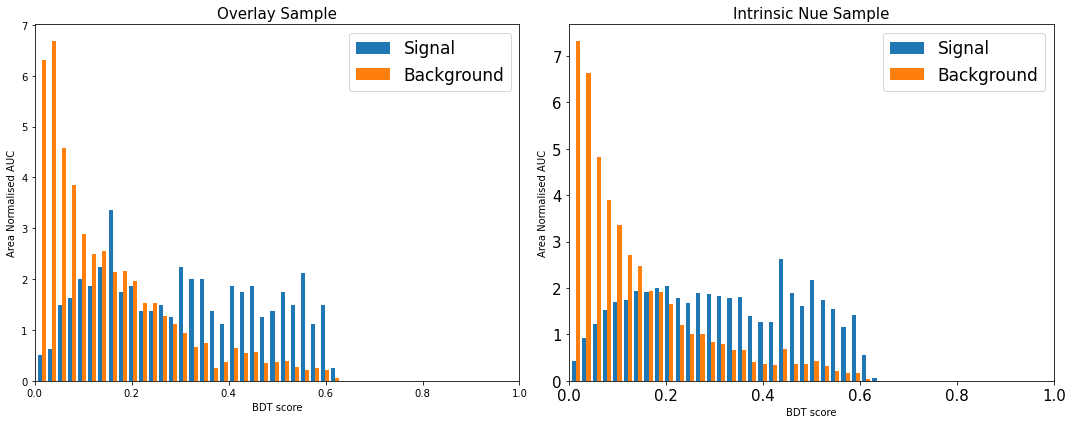

In [11]:
df_overlay_sig = isSignal(df_overlay)
df_overlay_bkg = delete_dataframe(df_overlay, df_overlay_sig)

df_intrinsic_nue_sig = isSignal(df_intrinsic_nue)
df_intrinsic_nue_bkg = delete_dataframe(df_intrinsic_nue, df_intrinsic_nue_sig) 
    
hist_list = [df_overlay_sig.antinue_score, df_overlay_bkg.antinue_score]
hist_list2 = [df_intrinsic_nue_sig.antinue_score, df_intrinsic_nue_bkg.antinue_score]
label_list = ['Signal', 'Background']

plt.close()
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(hist_list, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[0].legend(loc='best', ncol=1, prop={'size': 17})
axs[0].set_title('Overlay Sample', fontsize=size_letter)
axs[0].set_xlabel('BDT score')
axs[0].set_ylabel('Area Normalised AUC')
axs[0].set_xlim(0,1)

axs[1].hist(hist_list2, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[1].legend(loc='best', ncol=1, prop={'size': 17})
axs[1].set_title('Intrinsic Nue Sample', fontsize=size_letter)
axs[1].set_xlabel('BDT score')
axs[1].set_ylabel('Area Normalised AUC')
axs[1].set_xlim(0,1)

plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

plt.tight_layout()
plt.show()

In [ ]:
# distribuicao 2d BDT vs outra variavel

In [ ]:
# =========== #
#             #
#   KS TEST   #
#             #
# =========== #

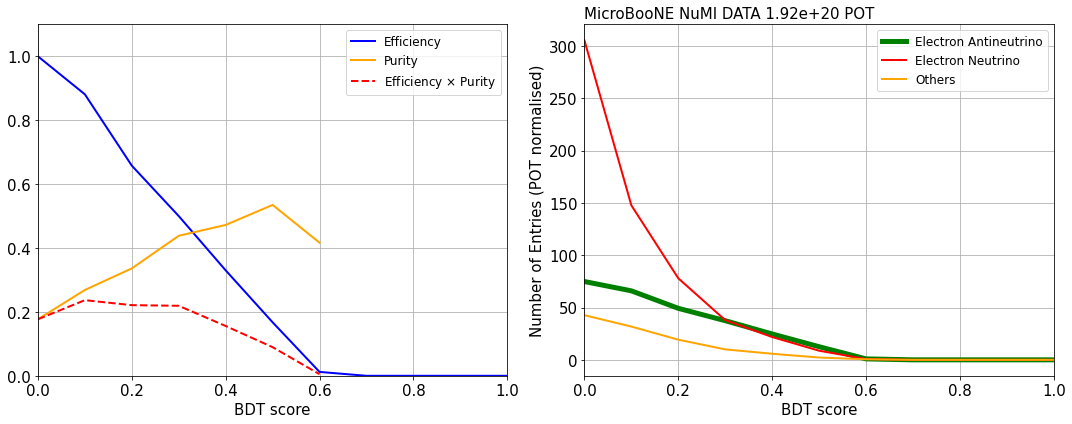

In [12]:
# ========================= #
#                           #
#   PURITY AND EFFICIENCY   #
#                           #
# ========================= #

arr_pur = []
arr_pur_x = []
arr_eff = []
arr_eff_x = []
arr_mult = [] # purity x efficiency
arr_mult_x = [] 

arr_nentries_antinue = []
arr_nentries_nue = []
arr_nentries_others = []
arr_nentries_x = []

step = 0.1           # choose the step
df = df_overlay       # choose which dataframe to use

var = 0
while(var <= 1):
    
    eff = -999
    pur = -999
    
    # --- efficiency
    df_eff_num = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_eff_num = apply_gen_nu_selection(df_eff_num)
    df_eff_den = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)]
    if(len(df_eff_den)!=0):
        eff = len(df_eff_num)/len(df_eff_den)
        arr_eff.append(eff)
        arr_eff_x.append(var)
        
    # --- purity
    df_pur_num = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_pur_den = df[df.antinue_score>var]
    if(len(df_pur_den)!=0):
        pur = len(df_pur_num)/len(df_pur_den)
        arr_pur.append(pur)
        arr_pur_x.append(var)
        
    # --- purity x efficiency
    if((eff!=-999) & (pur!=-999)):
        arr_mult.append(pur*eff)
        arr_mult_x.append(var)
        
    # --- nentries
    df_antinue = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    df_nue = df[(df.truth_nuPdg==12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.antinue_score>var)]
    
    df_rest = delete_dataframe(df, df_antinue) 
    df_rest = delete_dataframe(df_rest, df_nue)
    df_rest = df_rest[df_rest.antinue_score>var]
    
    nentries_antinue = len(df_antinue) * (POT_data/POT_mc)
    nentries_nue = len(df_nue) * (POT_data/POT_mc)
    nentries_rest = len(df_rest) * (POT_data/POT_mc)
    
    arr_nentries_antinue.append(nentries_antinue)
    arr_nentries_nue.append(nentries_nue)
    arr_nentries_others.append(nentries_rest)
    arr_nentries_x.append(var)
    
    var = var + step
        
# --- now that we have the arrays, let's plot them :)
plt.close()
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(arr_eff_x, arr_eff, c='blue', label='Efficiency', linewidth=2.0)
plt.plot(arr_pur_x, arr_pur, c='orange', label='Purity', linewidth=2.0)
plt.plot(arr_mult_x, arr_mult, c='red', linestyle='dashed', label=r'Efficiency $\times$ Purity', linewidth=2.0)
plt.grid()
plt.ylim([0,1.1])
plt.xlim([0,1])
plt.xlabel('BDT score', fontsize=size_letter)
plt.legend(loc='best', prop={'size': 12})
plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

plt.subplot(122)
plt.plot(arr_nentries_x, arr_nentries_antinue, c='green', label="Electron Antineutrino", linewidth=5.0)
plt.plot(arr_nentries_x, arr_nentries_nue, c='red', label="Electron Neutrino", linewidth=2.0)
plt.plot(arr_nentries_x, arr_nentries_others, c='orange', label="Others", linewidth=2.0)
plt.grid()
plt.xlim([0,1])
plt.xlabel('BDT score', fontsize=size_letter)
plt.ylabel('Number of Entries (POT normalised)', fontsize=size_letter)
plt.title('MicroBooNE NuMI DATA %.2e POT' % POT_data, loc='left', fontsize=size_letter)
plt.legend(loc='best', prop={'size': 12})
plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)
plt.tight_layout()
plt.show()

In [13]:
# --- explore the properties of the events above the bdt cut
# --- are their distribution the same?

bdt_cut = 0.5

# --- apply the bdt cut
df_bdt = df_overlay[df_overlay.antinue_score>bdt_cut]

# --- split remaining dataframe into signal and background
df_bdt_sig = isSignal(df_bdt)
df_bdg_bkg = delete_dataframe(df_bdt, df_bdt_sig)

# --- plot variables
def plot_2df(df1, df2, label1, label2):
    
    hist_list = [df1[var], df2[var]]
    label_list = [label1, label2]
    
    plt.hist(hist_list, label=label_list, bins=50, density=False)
    plt.legend(loc='best', ncol=1, prop={'size': 17})
    

# cut = 0.5
# check distributions for nue vs antinue

In [ ]:
df_overlay_sig = isSignal(df_overlay)
df_overlay_bkg = delete_dataframe(df_overlay, df_overlay_sig)

df_intrinsic_nue_sig = isSignal(df_intrinsic_nue)
df_intrinsic_nue_bkg = delete_dataframe(df_intrinsic_nue, df_intrinsic_nue_sig) 
    
hist_list = [df_overlay_sig.antinue_score, df_overlay_bkg.antinue_score]
hist_list2 = [df_intrinsic_nue_sig.antinue_score, df_intrinsic_nue_bkg.antinue_score]
label_list = ['Signal', 'Background']

plt.close()
fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].hist(hist_list, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[0].legend(loc='best', ncol=1, prop={'size': 17})
axs[0].set_title('Overlay Sample', fontsize=size_letter)
axs[0].set_xlabel('BDT score')
axs[0].set_ylabel('Area Normalised AUC')
axs[0].set_xlim(0,1)

axs[1].hist(hist_list2, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
axs[1].legend(loc='best', ncol=1, prop={'size': 17})
axs[1].set_title('Intrinsic Nue Sample', fontsize=size_letter)
axs[1].set_xlabel('BDT score')
axs[1].set_ylabel('Area Normalised AUC')
axs[1].set_xlim(0,1)

plt.yticks(fontsize=size_letter)
plt.xticks(fontsize=size_letter)

plt.tight_layout()
plt.show()

# Electron Antineutrino BDT

In [ ]:
# ============================= #
#                               #
#   ADD PARTICLE MULTIPLICITY   #
#                               #
# ============================= #

# --- create dataframes with the particle multiplicity information, the file must contain the particle flow information for that

#df_data_multiplicity = calc_particle_multiplicity(datafile)
#df_ext_multiplicity = calc_particle_multiplicity(extfile)
df_overlay_multiplicity = calc_particle_multiplicity(mcfile)
df_intrinsic_nue_multiplicity = calc_particle_multiplicity(intrinsicfile)

In [ ]:
# --- merge the dataframe with the particle multiplicity information, and the dataframe with the events after the selection cuts

#df_data = pd.merge(df_data, df_data_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
#df_ext = pd.merge(df_ext, df_ext_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
df_overlay = pd.merge(df_overlay, df_overlay_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')
df_intrinsic_nue = pd.merge(df_intrinsic_nue, df_intrinsic_nue_multiplicity, left_on=['run','subrun','event'], right_on=['run','subrun','event'], how='left')

In [ ]:
# --- define the dataframe that will be used for the second BDT

df_bdt2 = pd.concat([df_intrinsic_nue,df_overlay], ignore_index=True) # merge intrinsic nue + overlay for a better nue/antinue stat

In [ ]:
# --- let's plot a few variables comparing the distribution of antinue and nue

def plot_nue_vs_antinue(var, df):
    
    df_nue = df[df.truth_nuPdg==12]
    df_antinue = df[df.truth_nuPdg==-12]
    
    hist_list = [df_nue[var], df_antinue[var]]
    label_list = [r'$\nu_e$', r'$\bar{\nu}_e$']
    
    fig, axs = plt.subplots()
    axs.hist(hist_list, label=label_list, bins=30, density=True) # density=True (histogram integral = 1)
    axs.legend(loc='best', ncol=1, prop={'size': 17})
    axs.set_xlabel(var)
    
    if(os.path.isdir('plots/nue_vs_antinue')==False):
        os.makedirs('plots/nue_vs_antinue')
    plt.savefig('plots/nue_vs_antinue/%s.pdf' % var)

plot_nue_vs_antinue('truth_nuPdg', df_bdt2)
plot_nue_vs_antinue('cos_theta', df_bdt2)

## Start BDT Training

In [ ]:
# ================================ #
#                                  #
#   DEFINE SIGNAL AND BACKGROUND   #
#                                  #
# ================================ #

def isSignal2(df):
    df_ = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1)]        # antinueCC
    df_ = df_[df_.dist_vtx<1]                                   # good vertex reconstruction, less than 1 cm apart
    df_ = notCosmic(df_)                                        # good event reconstruction, not labelled as cosmic
    return df_

df_signal2 = isSignal2(df_bdt2)
df_background2 = delete_dataframe(df_bdt2,df_signal2) # background is everything that is not signal

if((len(df_signal2)+len(df_background2))!=(len(df_bdt2))): print('   > Ooops! Check your signal/background definition!')

In [ ]:
def split_train_val_test(df,tag):
    
    # this function splits the incoming dataframe into training,
    # validation and testing according to the percentages below
    
    df_test = df.iloc[(df.index % 3 == 0).astype(bool)].reset_index(drop=True)
    df_rest = df.iloc[(df.index % 3 != 0).astype(bool)].reset_index(drop=True)
    
    df_val = df_rest.iloc[(df_rest.index % 4 == 0).astype(bool)].reset_index(drop=True)
    df_train = df_rest.iloc[(df_rest.index % 4 != 0).astype(bool)].reset_index(drop=True)
    
    return df_train, df_val, df_test

def associate_variables(df_sig,df_bkg,list_var):

    df_sig = shuffle(df_sig).reset_index(drop=True)[list_var]
    df_bkg = shuffle(df_bkg).reset_index(drop=True)[list_var]

    # true label, 1=signal, 0=background
    df_sig.loc[:,'Y'] = 1
    df_bkg.loc[:,'Y'] = 0

    df = shuffle(pd.concat([df_sig,df_bkg]),random_state=1).reset_index(drop=True)

    x = df[df.columns[:-2]] # removes weight and Y for training
    y = df['Y']
    w = df['weight']

    return df, x, y, w

# ============================================ #
#                                              #
#   CREATE VALIDATION, TESTING, AND TRAINING   #
#                                              #
# ============================================ #

variables_w2 = ['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron','cos_theta','weight'] # keep 'weight' as the last one             
variables2 = ['Num_Neutron','Num_Muon','Num_Kaon','Num_Proton','Num_Gamma','Num_Electron','cos_theta']

# --- splits df_signal and df_background into train, validation, and testing dataframes according to the
# --- proportion defined in the function split_train_val_test

df_signal_train2, df_signal_val2, df_signal_test2 = split_train_val_test(df_signal2, 'Signal')
df_background_train2, df_background_val2, df_background_test2 = split_train_val_test(df_background2, 'Background')

# --- merges everything together to recover a single dataframe for training, validation, and testing
# --- each of those dataframes will have the same proportion of signal and background, defined in
# --- the function split_train_test

df_train2, x_train2, y_train2, w_train2 = associate_variables(df_signal_train2,df_background_train2, variables_w2)
df_val2, x_val2, y_val2, w_val2 = associate_variables(df_signal_val2,df_background_val2, variables_w2)
df_test2, x_test2, y_test2, w_test2 = associate_variables(df_signal_test2,df_background_test2, variables_w2)

# --- check if you did the correct splitting

n_sig2 = len(df_signal2)
n_bkg2 = len(df_background2)

n_train2 = len(df_train2)
n_val2 = len(df_val2)
n_test2 = len(df_test2)

if((n_train2+n_val2+n_test2)!=(n_sig2+n_bkg2)): print('   > Ooops!')

In [ ]:
def plot_bdt_score(model, df_signal_train, df_signal_test, df_background_train, df_background_test, variables):
    
    # the PDf plot is made to facilitate the comparison between training, testing and validation samples
    # the idea is that training, testing and validation samples have different number of entries, so it might be hard
    # to compare the distributions. If you have 20% for validation and 80% for training, then obviously in your 
    # comparison plot the validation is going to be 1/4 of the height and it makes it harder for you to compare them.
    # If you use the PDF, everything is normalised so the valyes you read on the Y axis don't really matter but you can
    # kinda understand wheter or not your training is ok. If you did overtrain the two distributions will probably not 
    # overlap especially in the region close to zero and in the region close to one, that's generally where the
    # training might differ
    
    pred_sig_train = model.predict_proba(df_signal_train[variables])[:,1] # column 1=success, 0=fail
    pred_sig_test = model.predict_proba(df_signal_test[variables])[:,1]
    pred_bkg_train = model.predict_proba(df_background_train[variables])[:,1]
    pred_bkg_test = model.predict_proba(df_background_test[variables])[:,1]
    
    plt.close()
    plt.figure(figsize=(15,5))
    nbins=50
    xrange=(0,1)

    plt.subplot(121)
    plt.hist(pred_sig_train, weights=df_signal_train['weight'], bins=nbins, range=xrange, density=True, color='red', alpha=0.5, label='Sig train (pdf)')
    plt.hist(pred_bkg_train, weights=df_background_train['weight'], bins=nbins, range=xrange, density=True, color='blue', alpha=0.5, label='Bkg train (pdf)')

    hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, weights=df_signal_test['weight'], bins=nbins, range=xrange, density=True, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test (pdf)', fmt='o')

    hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, weights=df_background_test['weight'], bins=nbins, range=xrange, density=True, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test (pdf)', fmt='o')

    plt.xlim(xrange)
    plt.xlabel('BDT score')
    plt.legend(loc='best', prop={'size': 12})

    plt.subplot(122)
    plt.hist(pred_sig_train, weights=df_signal_train['weight'], bins=nbins, range=xrange, color='red', alpha=0.5, label='Sig train')
    plt.hist(pred_bkg_train, weights=df_background_train['weight'], bins=nbins, range=xrange, color='blue', alpha=0.5, label='Bkg train')

    hist_sig_test, bins1, _1 = plt.hist(pred_sig_test, weights=df_signal_test['weight'], bins=nbins, range=xrange, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_sig_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='firebrick', label='Sig test', fmt='o')

    hist_bkg_test, bins1, _1 = plt.hist(pred_bkg_test, weights=df_background_test['weight'], bins=nbins, range=xrange, alpha=0)
    mid=0.5*(bins1[1:] + bins1[:-1])
    plt.errorbar(x=mid, y=hist_bkg_test, xerr=0.5*xrange[1]/nbins, yerr=[0]*nbins, c='navy', label='Bkg test', fmt='o')

    plt.xlim(xrange)
    plt.xlabel('BDT score')
    plt.legend(loc='best', prop={'size': 12})
    plt.show()
    
def plot_auc_error(model, n_estimators, auc_train, auc_val, error_train, error_val):
    plt.close()
    plt.figure(figsize=(15,5))

    plt.subplot(121)
    plt.plot(range(0,n_estimators), auc_train, c='blue', label='train')
    plt.plot(range(0,n_estimators), auc_val, c='orange', label='validation')
    ymin = min(min(auc_train),min(auc_val))
    ymax = max(max(auc_train),max(auc_val))
    plt.ylabel('AUC')
    plt.xlabel('Estimators')
    plt.ylim(ymin, ymax)
    plt.vlines(model.best_iteration, ymin=ymin, ymax=ymax, ls='--', color='red', label='best iteration', alpha=0.5)
    plt.legend(loc='best', prop={'size': 12})

    plt.subplot(122)
    plt.plot(range(0,n_estimators), error_train, c='blue', label='train')
    plt.plot(range(0,n_estimators), error_val, c='orange', label='validation')
    ymin = min(min(error_train),min(error_val))
    ymax = max(max(error_train),max(error_val))
    plt.ylabel('Classification Error')
    plt.xlabel('Estimators')
    plt.ylim(ymin, ymax)
    plt.vlines(model.best_iteration, ymin=ymin, ymax=ymax, ls='--', color='red', label='best iteration', alpha=0.5)
    plt.legend(loc='best', prop={'size': 12})
    
    plt.show()
    
def plot_important_features(features, feature_importances_, number, name, file):
    
    plt.close()
    plt.figure(figsize=(10,8))
    
    zipped = zip(features, feature_importances_)
    zipped_sort = sorted(zipped, key = lambda x:x[1], reverse=True)
    zipped_sort_reduced = zipped_sort[:number]
    
    res = [[ i for i, j in zipped_sort_reduced], 
           [ j for i, j in zipped_sort_reduced]]
    red_features = res[0]
    red_importances = res[1]
    
    plt.barh(range(len(red_importances)), red_importances, align='center')
    plt.yticks(np.arange(len(red_features)), red_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Top %i features"%(number))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1)
    plt.tight_layout()
    plt.show()
    
    return red_features
       
def plot_eff_purity(df):
    
    step = 0.01
    
    # efficiency
    arr_eff = []
    arr_eff_x = []
    
    # purity
    arr_pur = []
    arr_pur_x = []
    
    # efficiency x purity
    arr_mult = []
    arr_mult_x = []
    
    # number of antinue
    arr_nentries = []
    arr_nentries_x = []
    arr_nentries_antinue = []
    arr_nentries_nue = []
    arr_nentries_others = []
    
    var = 0
        
    while(var <= 1):
        
        pur = -999
        eff = -999
        
        # --- efficiency = how many signal events, among the original ones, survive to the bdt cut
        
        df_eff_den = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)] # denominator = total number of signal events originally
        
        df_eff_num = df[(df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1) & (df.bdt_score2>var)] # numerator = signal that survive to the bdt cut
        df_eff_num = apply_gen_nu_selection(df_eff_num) # and that was well reconstructed
        
        if(len(df_eff_den)!=0):
            eff = len(df_eff_num)/len(df_eff_den)
            arr_eff.append(eff)
            arr_eff_x.append(var)
            
        # --- purity = how many events among those selected are signal?
        
        df_pur_den = df[(df.bdt_score2>var)] # denominator = number of events selected after the bdt cut
        
        df_pur_num = df[(df.bdt_score2>var) & (df.truth_nuPdg==-12) & (df.truth_isCC==1) & (df.truth_vtxInside==1)] # numerator = number of SIGNAL events selected after the bdt cut
        
        if(len(df_pur_den)!=0):
            pur = len(df_pur_num)/len(df_pur_den)
            arr_pur.append(pur)
            arr_pur_x.append(var)
            
        # --- calculate purity X efficiency
        
        if((eff!=-999) & (pur!=-999)):
            arr_mult.append(pur*eff)
            arr_mult_x.append(var)
            
        # --- calculate the number of antinue that would be selected for a given bdt cut
        
        ratio = POT_data/POT_mc # check what would be the number of selected events for the DATA POT
        
        df_sel = df[df.bdt_score2>var]  # first, apply the bdt cut
        arr_nentries.append(len(df_sel)*ratio)
        arr_nentries_x.append(var)
        
        # antinue    
        df_antinue = df_sel[(df_sel.truth_nuPdg==-12) & (df_sel.truth_isCC==1) & (df_sel.truth_vtxInside==1)]
        df_antinue = apply_gen_nu_selection(df_antinue)
        arr_nentries_antinue.append(len(df_antinue)*ratio)
        
        # exclude from df_sel the events that are antinue
        df_sel = delete_dataframe(df_sel,df_antinue)
        
        # nue
        df_nue = df_sel[(df_sel.truth_nuPdg==12) & (df_sel.truth_isCC==1) & (df_sel.truth_vtxInside==1)]
        arr_nentries_nue.append(len(df_nue)*ratio)
        
        # exclude from df_sel the events that are nue
        df_sel = delete_dataframe(df_sel, df_nue)
        arr_nentries_others.append(len(df_sel)*ratio)
            
        var = var + step
            
    # --- now that we have the arrays, let's plot them :)
    
    size_letter = 15
    
    plt.close()
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(arr_eff_x, arr_eff, c='blue', label='Efficiency')
    plt.plot(arr_pur_x, arr_pur, c='orange', label='Purity')
    plt.plot(arr_mult_x, arr_mult, c='red', linestyle='dashed', label=r'Efficiency $\times$ Purity')
    plt.grid()
    plt.ylim([0,1.1])
    plt.xlim([0,1])
    plt.xlabel('BDT score', fontsize=size_letter)
    plt.ylabel('Percentage', fontsize=size_letter)
    plt.title('Overlay Sample', fontsize=size_letter)
    plt.legend(loc='best', prop={'size': 12})
    plt.yticks(fontsize=size_letter)
    plt.xticks(fontsize=size_letter)
    
    plt.subplot(122)
    plt.plot(arr_nentries_x, arr_nentries, c='blue', label='Pass BDT cut')
    plt.plot(arr_nentries_x, arr_nentries_antinue, c='green', label=r'$\bar{\nu}_e$', linewidth=7.0)
    plt.plot(arr_nentries_x, arr_nentries_nue, c='orange', label=r'$\nu_e$')
    plt.plot(arr_nentries_x, arr_nentries_others, c='red', label='Others')
    plt.grid()
    plt.title('MicroBooNE NuMI DATA %.2e POT' % POT_data, fontsize=size_letter)
    plt.ylabel('Number of Selected Events', fontsize=size_letter)
    plt.legend(loc='best', prop={'size': 20})
    plt.yticks(fontsize=size_letter)
    plt.xticks(fontsize=size_letter)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# ================ #
#                  #
#   BDT TRAINING   #
#                  #
# ================ #

print('\n\033[1m' + "Starting BDT training:" + '\033[0m\n')

use_label_encoder=False # removes warning message because XGBClassifier won't be used in future releases

model2 = XGBClassifier(#n_estimators=300,                 # maximum number of rounds    300
                      max_depth=5,                        # number of cuts              6
                      #scale_pos_weight = 1,              # sum(df_bkg_train.weight) / sum(df_sig_train.weight) (you should change it manually for your case)
                      learning_rate=0.05,                 # steps   0.05
                      objective='binary:logistic',        # bdt score 0-1
                      colsample_bytree=0.8,
                      use_label_encoder=False)            # remove warning

                                                                # understand the parameters: https://xgboost.readthedocs.io/en/latest/python/python_api.html
model2.fit(x_train2,                                            # feature matrix
          y_train2,                                             # labels (Y=1 signal, Y=0 background)
          sample_weight=w_train2,                               # instance weights
          eval_set = [(x_train2,y_train2), (x_val2,y_val2)],    # a list of (X,y) tuple pairs to use as validation sets ---> validation_0=train, validation_1=validation
          sample_weight_eval_set = [w_train2, w_val2],          # list of arrays storing instances weights for the i-th validation set
          eval_metric = ['auc', 'error'],                       # list of parameters under eval_metric: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
          early_stopping_rounds=50,                             # validation metric needs to improve at least once in every early_stopping_rounds round(s)
          verbose=90)

results2 = model2.evals_result()                            # takes the results from the BDT training above
n_estimators2 = len(results2['validation_0']['error'])      # number of rounds used for the BDT training
auc_train2 = results2['validation_0']['auc']                # subsample: auc for training
auc_val2 = results2['validation_1']['auc']                  # subsample: auc for validation
error_train2 = results2['validation_0']['error']            # subsample: error for training
error_val2 = results2['validation_1']['error']              # subsample: error for validation

# ============================================= #
#                                               #
#   SAVE THE BDT SCORE BACK IN THE DATAFRAMES   #
#                                               #
# ============================================= #

df_overlay.loc[:,'bdt_score2'] = model2.predict_proba(df_overlay[variables2])[:,1]
df_intrinsic_nue.loc[:,'bdt_score2'] = model2.predict_proba(df_intrinsic_nue[variables2])[:,1]
#df_ext2.loc[:,'bdt_score2'] = model2.predict_proba(df_ext2[variables2])[:,1]
#df_data2.loc[:,'bdt_score2'] = model2.predict_proba(df_data2[variables2])[:,1]

# ============== #
#                #
#   MAKE PLOTS   #
#                #
# ============== #

plot_auc_error(model2, n_estimators2, auc_train2, auc_val2, error_train2, error_val2)
plot_bdt_score(model2, df_signal_train2, df_signal_test2, df_background_train2, df_background_test2, variables2)
plot_eff_purity(df_overlay)
list_feat = plot_important_features(variables_w2[:-1], model2.feature_importances_, 6, 'NC', 'important_features_bdt2')

In [ ]:
# plot the BDT score distribution for the dataframes, signal and background

df_overlay_sig = isSignal2(df_overlay)
df_overlay_bkg = delete_dataframe(df_overlay, df_overlay_sig)

df_intrinsic_nue_sig = isSignal2(df_intrinsic_nue)
df_intrinsic_nue_bkg = delete_dataframe(df_intrinsic_nue, df_intrinsic_nue_sig)   
    
def plot_bdt_signal_background(df_sig, df_bkg):
    
    hist_list = [df_sig.bdt_score2, df_bkg.bdt_score2]
    label_list = ['Signal', 'Background']
    fig, axs = plt.subplots()
    axs.hist(hist_list, label=label_list, bins=100, density=True) # density=True (histogram integral = 1)
    axs.legend(loc='best', ncol=1, prop={'size': 17})
    axs.set_xlabel('BDT score')
    axs.set_ylabel('Area Normalised AUC')
    
plot_bdt_signal_background(df_overlay_sig, df_overlay_bkg)
plot_bdt_signal_background(df_intrinsic_nue_sig, df_intrinsic_nue_bkg)